In [ ]:
!pip install PennyLane

# Importing the Necessary Libraries

In [68]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import os
import cv2
import time 
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report
import pennylane as qml
from torchmetrics.classification import MulticlassF1Score,MulticlassRecall,MulticlassPrecision,MulticlassAccuracy,MulticlassConfusionMatrix

# Loading the Dataset

In [2]:
train_path = '/kaggle/input/tig-aluminium-5083/al5083/train/'
test_path = '/kaggle/input/tig-aluminium-5083/al5083/test/'

labels_ = {'0':'good weld',
          '1':'burn through',
          '2':'contamination',
          '3':'lack of fusion',
          '4':'misalignment',
          '5':'lack of penetration'}

In [3]:
# Loading the json files consisting of train and test image paths and labels

train_dict_ = json.load(open(train_path + 'train.json'))
test_dict_ = json.load(open(test_path + 'test.json'))

In [4]:
# Getting the image paths and labels in a list
def get_data_from_dict(data_dict_,ds):
    img_paths_ = list(data_dict_.keys())
    labels = list(data_dict_.values())
    print(f"No. of {ds} Images {len(img_paths_)}")
    return img_paths_,labels

In [5]:
train_img_paths,train_labels = get_data_from_dict(train_dict_,'train')
test_img_paths,test_labels = get_data_from_dict(test_dict_,'test')

No. of train Images 26666
No. of test Images 6588


In [6]:
# Displaying the image and printing the respective label with index

def plot_image(img_paths_,labels,random=True):
    if random:
        i = np.random.choice(len(img_paths_))
        print(i)
    key = img_paths_[i]
    label = str(labels[i])
    im_path = train_path + key.split('/')[-2] + '/' + key.split('/')[-1]
    img = cv2.imread(im_path)
    plt.imshow(img);
    plt.title(labels_[label])
    plt.show()

15839


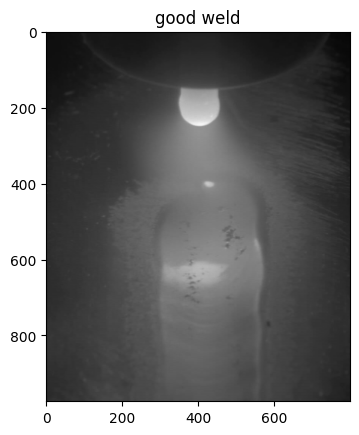

In [7]:
plot_image(train_img_paths,train_labels)

In [8]:
# Storing the image paths and labels in a pandas dataframe

def get_df(img_paths,labels):
    new_df = pd.DataFrame()
    new_df['Images'] = img_paths
    new_df['Labels'] = labels
    new_df.insert(2,'Label Names',[labels_[str(val)] for val in new_df['Labels']])
    
    return new_df

In [9]:
Train_df = get_df(train_img_paths,train_labels)
Test_df = get_df(test_img_paths,test_labels)

In [10]:
Train_df.Labels.value_counts()

Labels
0    8758
2    6325
3    4028
4    2953
5    2819
1    1783
Name: count, dtype: int64

# Plotting the Label counts

## Count of labels in Train dataset

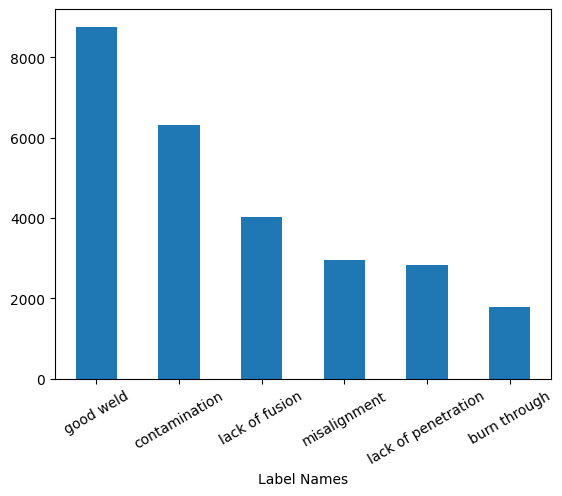

In [11]:
Train_df['Label Names'].value_counts().plot(kind='bar',rot=30);

## Count of labels in Test dataset

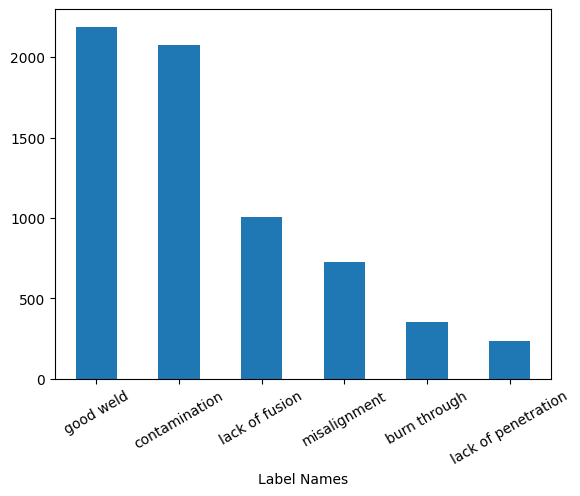

In [12]:
Test_df['Label Names'].value_counts().plot(kind='bar',rot=30);

In [13]:
Test_df['Label Names'].value_counts()

Label Names
good weld              2189
contamination          2078
lack of fusion         1007
misalignment            729
burn through            351
lack of penetration     234
Name: count, dtype: int64

In [14]:
labels_.values()

dict_values(['good weld', 'burn through', 'contamination', 'lack of fusion', 'misalignment', 'lack of penetration'])

# Balancing the Train and Test Labels

In [15]:
train_dfs_list = []
test_dfs_list = []

for lbl in labels_.values():
    if lbl == 'burn through':
        train_dfs_list.append(Train_df[Train_df['Label Names'] == lbl])
    else:
        train_dfs_list.append(Train_df[Train_df['Label Names'] == lbl].sample(2000))

for lbl in labels_.values():
    test_dfs_list.append(Test_df[Test_df['Label Names'] == lbl].sample(230))
        
train_df_final = pd.concat(train_dfs_list)
test_df_final = pd.concat(test_dfs_list)

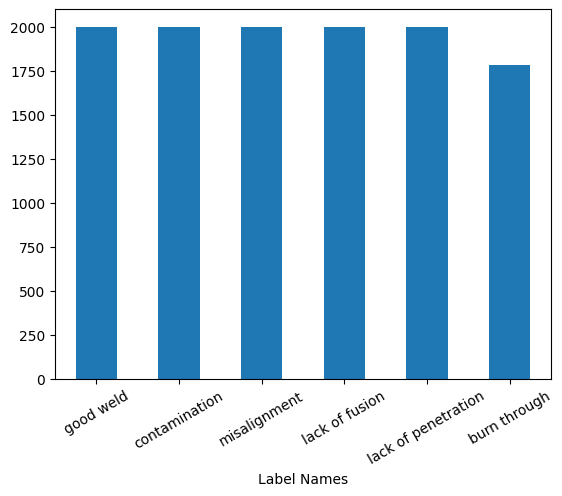

In [16]:
train_df_final['Label Names'].value_counts().plot(kind='bar',rot=30);

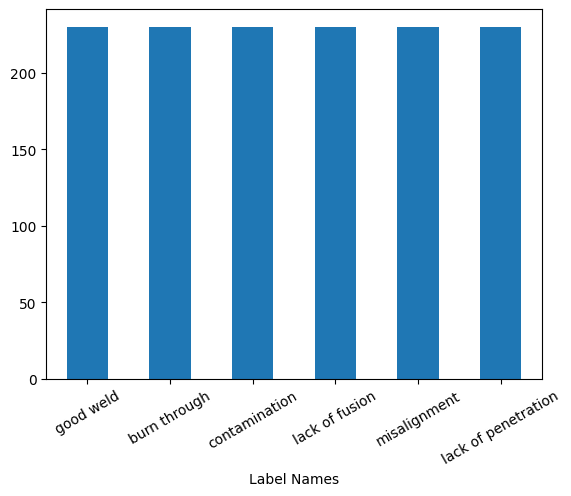

In [17]:
test_df_final['Label Names'].value_counts().plot(kind='bar',rot=30);

In [18]:
train_df_final.Images = train_path + train_df_final.Images
test_df_final.Images = test_path + test_df_final.Images

In [19]:
# Splitting the train and test set with 70-30 split

Total_df = pd.concat([train_df_final,test_df_final])

X = Total_df.drop('Labels',axis=1)
y = Total_df.Labels

X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.7,stratify=y,random_state=2529)

In [20]:
Train_dff = pd.concat([X_train,y_train],axis=1)
Test_dff = pd.concat([X_test,y_test],axis=1)

In [21]:
Train_dff#.Labels.value_counts()

,Images,Label Names,Labels
3563,/kaggle/input/tig-aluminium-5083/al5083/train/...,contamination,2
22619,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of penetration,5
24355,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of fusion,3
3748,/kaggle/input/tig-aluminium-5083/al5083/train/...,contamination,2
702,/kaggle/input/tig-aluminium-5083/al5083/train/...,burn through,1
...,...,...,...
21612,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of penetration,5
22412,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of penetration,5
18434,/kaggle/input/tig-aluminium-5083/al5083/train/...,good weld,0
25633,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of fusion,3


In [22]:
Test_dff

,Images,Label Names,Labels
14766,/kaggle/input/tig-aluminium-5083/al5083/train/...,good weld,0
226,/kaggle/input/tig-aluminium-5083/al5083/train/...,burn through,1
425,/kaggle/input/tig-aluminium-5083/al5083/train/...,burn through,1
24574,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of fusion,3
6126,/kaggle/input/tig-aluminium-5083/al5083/test/1...,lack of fusion,3
...,...,...,...
20729,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of penetration,5
7354,/kaggle/input/tig-aluminium-5083/al5083/train/...,contamination,2
5221,/kaggle/input/tig-aluminium-5083/al5083/train/...,contamination,2
25104,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of fusion,3


In [23]:
train_df_final = pd.concat([Train_dff,pd.get_dummies(Train_dff.Labels, dtype=int)],axis=1)
test_df_final = pd.concat([Test_dff,pd.get_dummies(Test_dff.Labels, dtype=int)],axis=1)

In [24]:
test_df_final.head()

,Images,Label Names,Labels,0,1,2,3,4,5
14766,/kaggle/input/tig-aluminium-5083/al5083/train/...,good weld,0,1,0,0,0,0,0
226,/kaggle/input/tig-aluminium-5083/al5083/train/...,burn through,1,0,1,0,0,0,0
425,/kaggle/input/tig-aluminium-5083/al5083/train/...,burn through,1,0,1,0,0,0,0
24574,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of fusion,3,0,0,0,1,0,0
6126,/kaggle/input/tig-aluminium-5083/al5083/test/1...,lack of fusion,3,0,0,0,1,0,0


# Define the Torch Dataset

In [26]:
class DataSet_gen(torch.utils.data.Dataset):
    def __init__(self,df):
        self.df = df

    def __getitem__(self,index):
        im_path = self.df.iloc[index].values[0]
        label = self.df.iloc[index].values[2]
        img = cv2.imread(im_path)
        img = cv2.resize(img, (256, 256))
        img = img.astype(np.float32)
        img = img/255.
        img = torch.from_numpy(img).permute(2, 0, 1)
        
        return img,label

    def __len__(self):
        return len(self.df)

In [27]:
trainset = DataSet_gen(train_df_final)
testset = DataSet_gen(test_df_final)

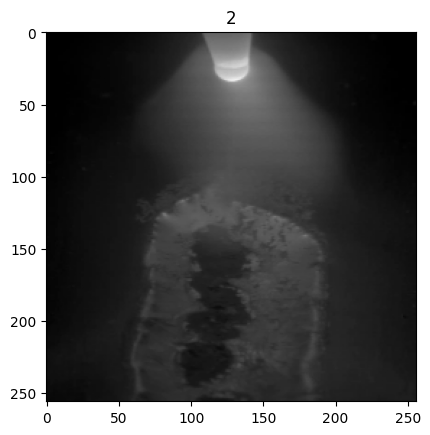

In [28]:
plt.imshow(trainset[0][0].permute(1,2,0));
plt.title(trainset[0][1])
plt.show()

In [29]:
# Defining the train and test loader that will be required for training and testing

train_loader = DataLoader(dataset=trainset,batch_size=64,shuffle=True)
test_loader = DataLoader(dataset=testset,batch_size=64,shuffle=False)

# Train and Test set size

In [30]:
len(trainset), len(testset)

(9214, 3949)

In [31]:
for images, labels in train_loader:
    break

print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([64, 3, 256, 256])
One batch label shape : torch.Size([64])


# Device Required for Running the circuit

In [32]:
dev = qml.device("default.qubit", wires=6)

@qml.qnode(dev)
def qnode(inputs, weights):
    n_qubits = 6
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

# Defining the Hybrid CNN Model

In [33]:
class ImageModel(nn.Module):
    def __init__(self,qnode):
        super(ImageModel, self).__init__()
        
        weight_shapes = {"weights": (6,6)} # Defining the shape of weights
        self.qlayer = qml.qnn.TorchLayer(qnode, weight_shapes) # Torch layer consisting of device and weight shapes
      
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5,5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4,4), stride=2),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5,5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4,4), stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4,4), stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), padding=1),
            nn.ReLU(),
        )

        self.maxpool = nn.MaxPool2d(kernel_size=(4,4), stride=2)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(9216,6400),
            nn.ReLU(),
            nn.Linear(6400,2048),
            nn.ReLU(),
            nn.Linear(2048,512),
            nn.ReLU(),
            nn.Linear(512,6),
            qml.qnn.TorchLayer(qnode, weight_shapes), ## Passing the torch layer
            nn.Linear(6,6)
        )

        self.gradient = None

    def activation_hook(self,grad): #get gradients
        self.gradient = grad

    def forward(self,images):
        x = self.feature_extractor(images) #activation_maps
        if x.requires_grad:
            h =  x.register_hook(self.activation_hook)
        x = self.maxpool(x)
        x = self.classifier(x)
        x = self.qlayer(x)

        return x

    def get_activation_gradients(self): #a1,a2... (weights)
        return self.gradient

    def get_activation(self,x):
        return self.feature_extractor(x)

In [34]:
# Setting the device to cuda as we will be running our experiments on GPU

device = 'cuda'

model = ImageModel(qnode)
model.to(device)

ImageModel(
  (qlayer): <Quantum Torch Layer: func=qnode>
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9216, out_features=6400, bias=True)
    (2): ReLU()
    (3): Linear(in_features=6

# Training function to train the model

In [35]:
def train_fn(dataloader,model,optimizer,criterion):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    for images,labels in tqdm(dataloader,colour='blue'):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits,labels)
        
        _, predicted = torch.max(logits, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    accuracy = 100 * total_correct / total_samples
    
    return total_loss / len(dataloader), accuracy

#  Eval function to test the model

In [36]:
def eval_fn(dataloader,model,criterion):
    model.eval()
    total_correct = 0
    total_loss = 0.0
    total_samples = 0
    
    for images,labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits,labels)
        
        _, predicted = torch.max(logits, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        total_loss += loss.item()

    accuracy = 100 * total_correct / total_samples
    return total_loss / len(dataloader),accuracy

In [37]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

# Model Training

In [38]:
best_valid_loss = np.Inf
useful_stuff = {'training_loss':[],'training_accuracy':[],
                'testing_loss':[],'testing_accuracy':[]}

# store starting time 
begin = time.time() 

for i in range(10):
    train_loss,train_acc = train_fn(train_loader,model,optimizer,criterion)
    test_loss,test_acc = eval_fn(test_loader,model,criterion)
    
    useful_stuff['training_loss'].append(train_loss)
    useful_stuff['training_accuracy'].append(train_acc)

    useful_stuff['testing_loss'].append(test_loss)
    useful_stuff['testing_accuracy'].append(test_acc)

    if test_loss < best_valid_loss:
        torch.save(model.state_dict(),'best_weights_.pt')
        best_valid_loss = test_loss
        print("Weights savedd.")

    print(f'Epoch: {i+1} Train Loss: {train_loss} Train Accuracy: {train_acc} Test Loss: {test_loss} Test Accuracy: {test_acc}')

end = time.time()  
# total time taken 
print(f"Total runtime of the QCNN Model is {end - begin}") 

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 1 Train Loss: 1.7772625899977155 Train Accuracy: 17.92923811591057 Test Loss: 1.7344588925761562 Test Accuracy: 42.87161306659914


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 2 Train Loss: 1.6460093789630466 Train Accuracy: 52.85435207293249 Test Loss: 1.5573347249338705 Test Accuracy: 66.04203595847049


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 3 Train Loss: 1.4720724721749623 Train Accuracy: 68.53700889950076 Test Loss: 1.4002436187959486 Test Accuracy: 72.49936692833629


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 4 Train Loss: 1.3817908689379692 Train Accuracy: 76.14499674408509 Test Loss: 1.354266308969067 Test Accuracy: 79.94428969359332


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 5 Train Loss: 1.3464203650752704 Train Accuracy: 82.34208812676363 Test Loss: 1.330603143861217 Test Accuracy: 89.97214484679665


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 6 Train Loss: 1.3233689583010144 Train Accuracy: 90.1996961146082 Test Loss: 1.3088237643241882 Test Accuracy: 92.68169156748544


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 7 Train Loss: 1.3089745839436848 Train Accuracy: 91.79509442153245 Test Loss: 1.3087312559927664 Test Accuracy: 91.01038237528488


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 8 Train Loss: 1.2893163652883635 Train Accuracy: 93.01063598871283 Test Loss: 1.279921531677246 Test Accuracy: 93.69460622942518


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 9 Train Loss: 1.2691428404715326 Train Accuracy: 94.33470805296288 Test Loss: 1.2647121087197335 Test Accuracy: 93.64396049632819


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 1.2611077469256189 Train Accuracy: 94.4649446494465 Test Loss: 1.2677955454395664 Test Accuracy: 93.61863762977968
Total runtime of the QCNN Model is 1908.0356781482697


# Model Loss

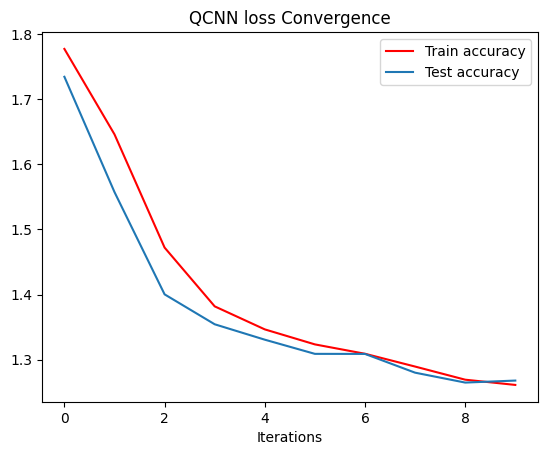

In [43]:
# Plot loss convergence
plt.plot(useful_stuff['training_loss'],'r')
plt.plot(useful_stuff['testing_loss'])
plt.title("QCNN loss Convergence")
plt.legend(["Train accuracy", "Test accuracy"], loc="upper right")
plt.xlabel("Iterations")
plt.show()

# Model Accuracy

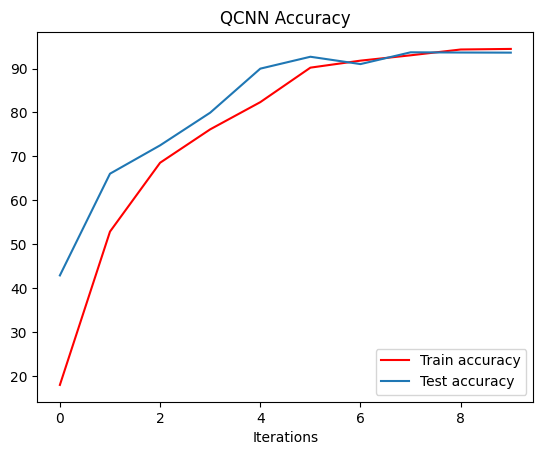

In [44]:
# Plot loss convergence
plt.plot(useful_stuff['training_accuracy'],'r')
plt.plot(useful_stuff['testing_accuracy'])
plt.title("QCNN Accuracy")
plt.xlabel("Iterations")
plt.legend(["Train accuracy", "Test accuracy"], loc="lower right")
plt.show()

**Gradient-weighted Class Activation Mapping
(Grad-CAM), uses the gradients of any target concept (say
‘dog’ in a classification network or a sequence of words
in captioning network) flowing into the final convolutional
layer to produce a coarse localization map highlighting the
important regions in the image for predicting the concept.**

In [45]:
def get_GradCam(model,image,label,size):
    label.backward()
    gradients = model.get_activation_gradients() #weights
    pooled_grads = torch.mean(gradients,dim=[0,2,3])
    activations = model.get_activation(image).detach() #get activation map

    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_grads[i]

    heatmap = torch.mean(activations,dim=1).squeeze().cpu()
    heatmap = nn.ReLU()(heatmap)
    heatmap /= torch.max(heatmap)
    heatmap = cv2.resize(heatmap.numpy(),(size,size))

    return heatmap

# Plot the heatmap on Image to see what regions has the model learned

In [47]:
def plot_heatmap(denorm_image, label,pred, heatmap):

    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20,20), ncols=3)

    classes = list(labels_.values())
    ps = torch.nn.Softmax(dim = 1)(pred).cpu().detach().numpy()
    ax1.imshow(denorm_image)
    ax1.set_title(classes[label],color='green')
    ax2.barh(classes, ps[0])
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    ax3.imshow(denorm_image)
    ax3.imshow(heatmap, cmap='magma', alpha=0.7)

In [48]:
labels_.values()

dict_values(['good weld', 'burn through', 'contamination', 'lack of fusion', 'misalignment', 'lack of penetration'])

# Lets understand the Model's Learning with the help of grad-CAM

## Example 1

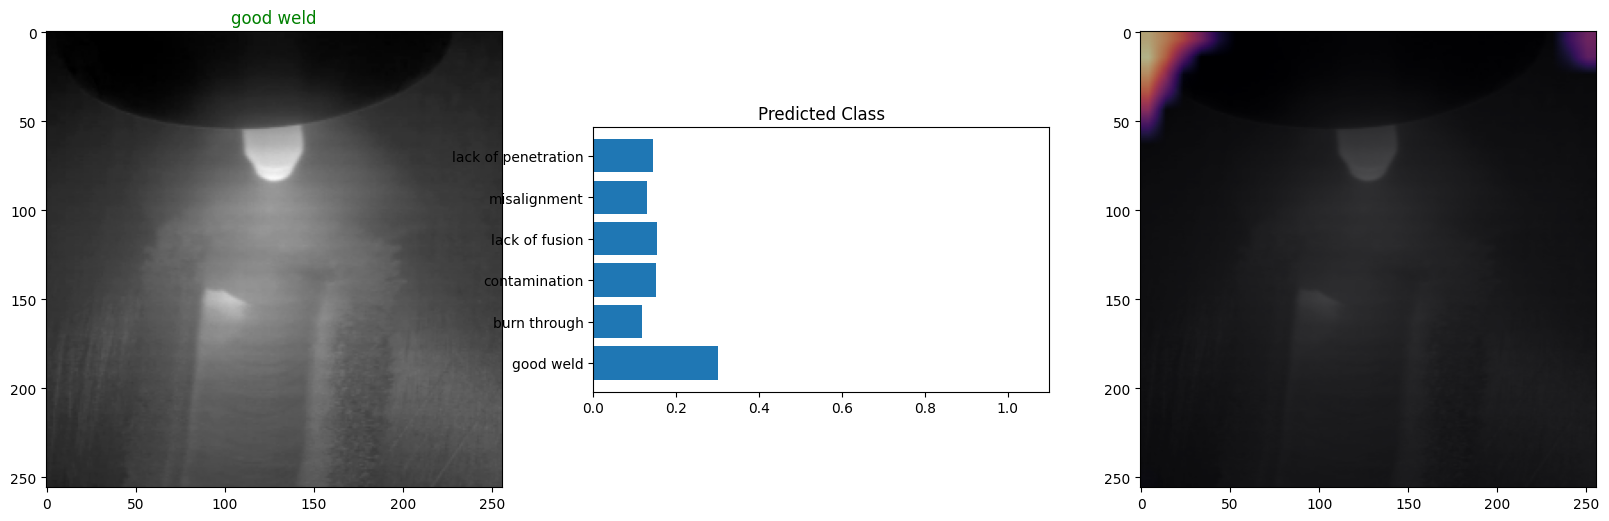

In [58]:
# 0 -> good weld'; 1-> 'burn through';  2-> 'contamination', 
# 3-> 'lack of fusion'; 4-> 'misalignment' 5-> 'lack of penetration'

image,label = testset[0]
denorm_image = image.permute(1,2,0) 
image = image.unsqueeze(0)
image = image.to(device)
pred = model(image)
heatmap = get_GradCam(model,image,pred[0][0],size=256)
plot_heatmap(denorm_image,label,pred,heatmap)

## Example 2

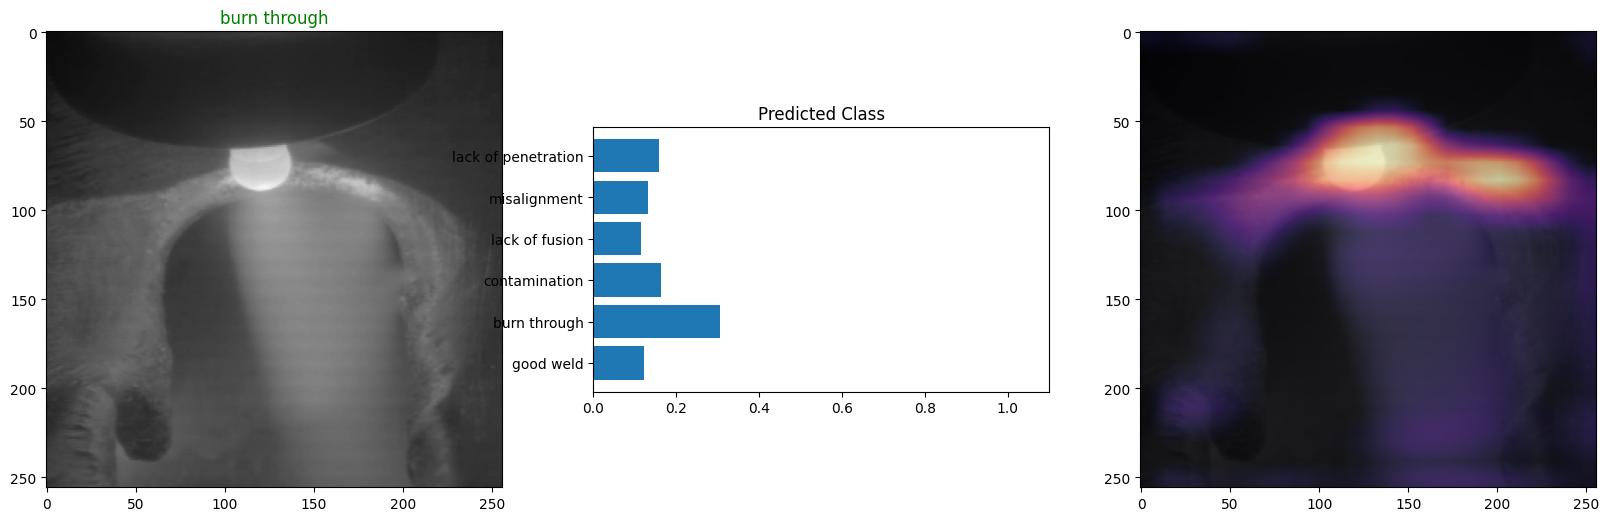

In [59]:
#dict_values(['good weld', 'burn through', 'contamination', #
#        'lack of fusion', 'misalignment', 'lack of penetration'])


image,label = testset[1]

denorm_image = image.permute(1,2,0) #* np.array((0.229,0.224,0.225)) + np.array((0.485,0.456,0.406))

image = image.unsqueeze(0)#.to(device)
image = image.to(device)
pred = model(image)
heatmap = get_GradCam(model,image,pred[0][1],size=256)
plot_heatmap(denorm_image,label,pred,heatmap)

## Example 3

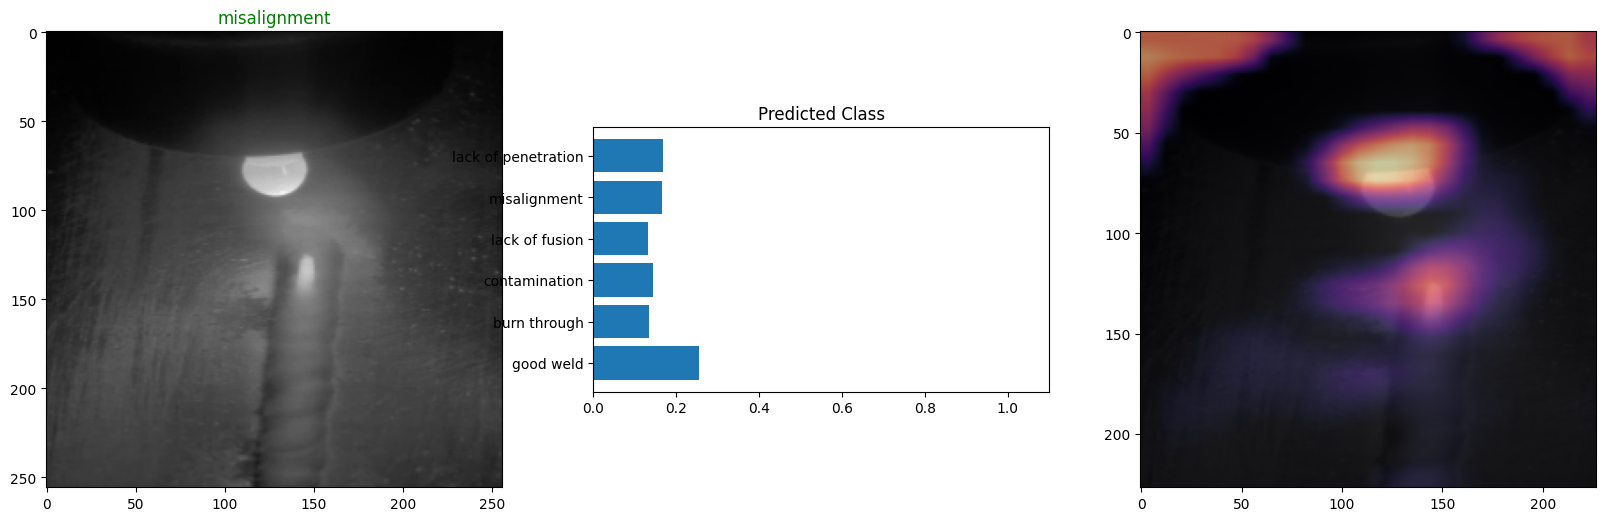

In [60]:
#dict_values(['good weld', 'burn through', 'contamination',
#'lack of fusion', 'misalignment', 'lack of penetration'])

image,label = testset[10]

denorm_image = image.permute(1,2,0) #* np.array((0.229,0.224,0.225)) + np.array((0.485,0.456,0.406))

image = image.unsqueeze(0).to(device)
pred = model(image)
heatmap = get_GradCam(model,image,pred[0][4],size=227)
plot_heatmap(denorm_image,label,pred,heatmap)

## Example 4

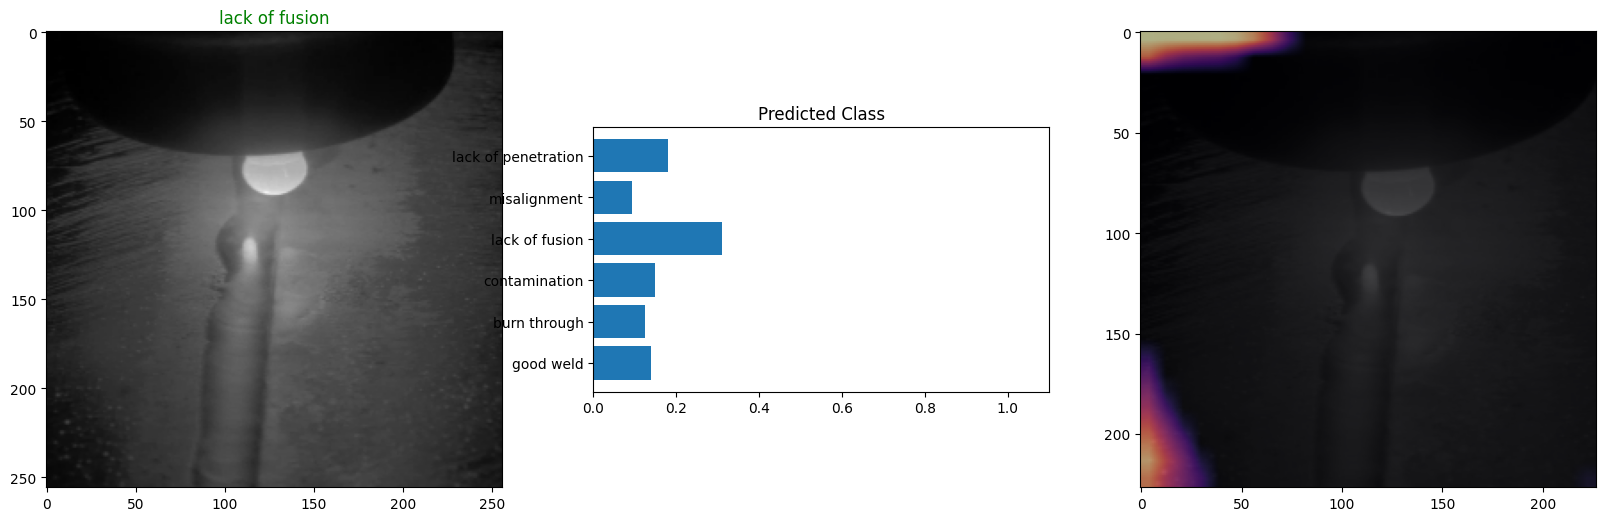

In [61]:
#dict_values(['good weld', 'burn through', 'contamination',
#'lack of fusion', 'misalignment', 'lack of penetration'])

image,label = testset[3]

denorm_image = image.permute(1,2,0) 

image = image.unsqueeze(0).to(device)
pred = model(image)
heatmap = get_GradCam(model,image,pred[0][3],size=227)
plot_heatmap(denorm_image,label,pred,heatmap)

## Example 5

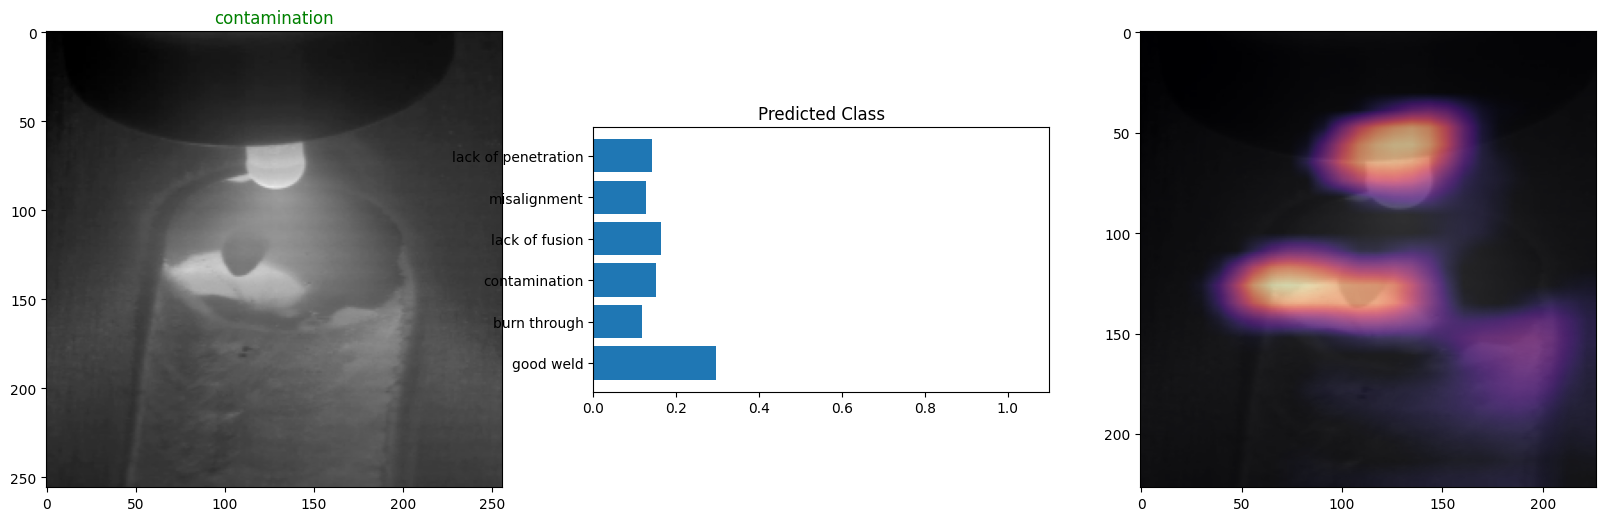

In [62]:
#dict_values(['good weld', 'burn through', 'contamination',
#'lack of fusion', 'misalignment', 'lack of penetration'])

image,label = testset[5]

denorm_image = image.permute(1,2,0) 

image = image.unsqueeze(0).to(device)
pred = model(image)
heatmap = get_GradCam(model,image,pred[0][2],size=227)
plot_heatmap(denorm_image,label,pred,heatmap)

## Example 6

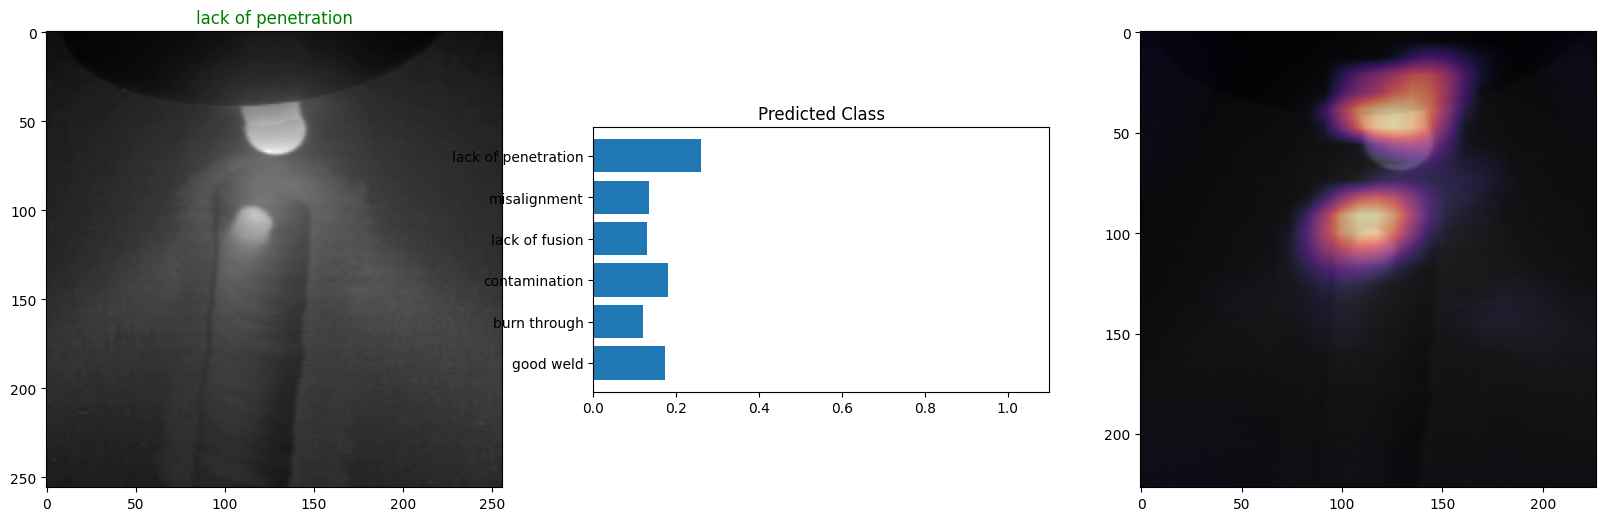

In [55]:
image,label = testset[100]

denorm_image = image.permute(1,2,0) 

image = image.unsqueeze(0).to(device)
pred = model(image)
heatmap = get_GradCam(model,image,pred[0][5],size=227)
plot_heatmap(denorm_image,label,pred,heatmap)

# Analyzing the results acheived with Gradcam

**Example 1:** The model is able to classify the image and correctly predict the label which is `good weld` but still we cannot see the heatmap on the resulting image. **which means that the QCNN failed to capture any relevant features**

**Example 2 :** The model is also able to classify this example and correctly predict the label which is `burn through` here the heatmap is clearly visible in the region of interest **which tells us that that model has learned the features and the region of interest is highlighted as well. The resulting heatmap obtained highlights the region of interest better than CNN.**

**Example 3:** The model predicted the wrong label in this example. The heatmap is visible in the region of interest.

**Example 4:** The model is able to classify the image and correctly predict the label which is `lack of fusion` but still we cannot see the heatmap on the resulting image. **which means that the QCNN has failed to capture any relevant features.**

**Example 5:** The model failed classify the image and predicted the label as `good weld` but still we cannot see the heatmap on the region of interest. The results shown here are not helpful as the **CNN failes to classify the image correctly.**

**Example 6:** The model is able to classify the image and correctly predict the label which is `lack of penetration` **the heatmap is also visible the the region of interest so the model is able to learn the features correctly**


The analysis from these examples tells us that model being able to classify the images with 93% accuracy which is less than CNN. The target predicted in 2 out of 5 examples are wrong; QCNN was successful in classifying other 2 examples and highlighting the region of interest as well with gradcam. 

*The difference between CNN and QCNN here is that QCNN is able to learn the features of the image as we can see in the heatmaps obtained. The classification of labels is not accurate and can be improved with additional epochs. The next set of experiments would be training the model with more epochs and seeing if the QCNN is able to classify the labels correctly and highlight the regions of interest as well.*

In [63]:
def check_accuracy(loader, model):
        num_correct = 0
        num_samples = 0
        preds = []
        y_true = []
        model.eval()

        with torch.no_grad():
            for x, y in loader:
                x = x.to(device)
                y = y.to(device)
                scores = model(x)
                _, predictions = scores.max(1)
                num_correct += (predictions == y.squeeze()).sum()
                num_samples += predictions.size(0)
                
                preds.append(scores.to('cpu'))
                y_true.append(y.to('cpu'))
                
            acc = float(num_correct)/float(num_samples)*100
            print(f'Got {num_correct} / {num_samples} with accuracy {acc:.2f}')
        
        model.train()
        
        metrica = MulticlassAccuracy(num_classes=6)
        metricp = MulticlassPrecision(num_classes=6)
        metricr = MulticlassRecall(num_classes=6)
        metricf = MulticlassF1Score(num_classes=6)
        
        metricat = MulticlassAccuracy(num_classes=6,average=None)
        metricpt = MulticlassPrecision(num_classes=6,average=None)
        metricrt = MulticlassRecall(num_classes=6,average=None)
        metricft = MulticlassF1Score(num_classes=6,average=None)
        
        print('Total Accuracy :', metrica(torch.cat(preds), torch.cat(y_true)).item() * 100)
        print('Total Precision :', metricp(torch.cat(preds), torch.cat(y_true)).item() * 100)
        print('Total Recall :', metricr(torch.cat(preds), torch.cat(y_true)).item() * 100)
        print('Total F1-score :', metricf(torch.cat(preds), torch.cat(y_true)).item() * 100)
        print()
        print('Accuracy for Each Classes:', metricat(torch.cat(preds), torch.cat(y_true)) * 100)
        print('Precision for Each Classes:', metricpt(torch.cat(preds), torch.cat(y_true)) * 100)
        print('Recall for Each Classes:', metricrt(torch.cat(preds), torch.cat(y_true)) * 100)
        print('F1-score for Each Classes:', metricft(torch.cat(preds), torch.cat(y_true)) * 100) 

In [65]:
check_accuracy(test_loader,model)

Got 3697 / 3949 with accuracy 93.62
Total Accuracy : 93.68444085121155
Total Precision : 94.30801272392273
Total Recall : 93.68444085121155
Total F1-score : 93.68702173233032

Accuracy for Each Classes: tensor([94.4694, 97.6821, 78.0269, 99.8505, 94.9178, 97.1599])
Precision for Each Classes: tensor([80.5096, 99.8308, 99.0512, 99.5529, 93.1085, 93.7951])
Recall for Each Classes: tensor([94.4694, 97.6821, 78.0269, 99.8505, 94.9178, 97.1599])
F1-score for Each Classes: tensor([86.9326, 98.7448, 87.2910, 99.7015, 94.0044, 95.4479])


In [67]:
import pickle as pkl
with open('/kaggle/working/QCNN_results.pkl','wb') as f:
    pkl.dump(useful_stuff,f)

In [72]:
def plot_CM(loader, model):
        num_correct = 0
        num_samples = 0
        preds = []
        y_true = []
        model.eval()

        with torch.no_grad():
            for x, y in loader:
                x = x.to(device)
                y = y.to(device)
                scores = model(x)
                _, predictions = scores.max(1)
                num_correct += (predictions == y.squeeze()).sum()
                num_samples += predictions.size(0)
                
                preds.append(scores.to('cpu'))
                y_true.append(y.to('cpu'))
                
            acc = float(num_correct)/float(num_samples)*100
            print(f'Got {num_correct} / {num_samples} with accuracy {acc:.2f}')
        
        metric = MulticlassConfusionMatrix(num_classes=6)
        metric.update(torch.cat(preds), torch.cat(y_true))
        fig_, ax_ = metric.plot()
        
        model.train()

# Confusion Matrix

Got 3697 / 3949 with accuracy 93.62


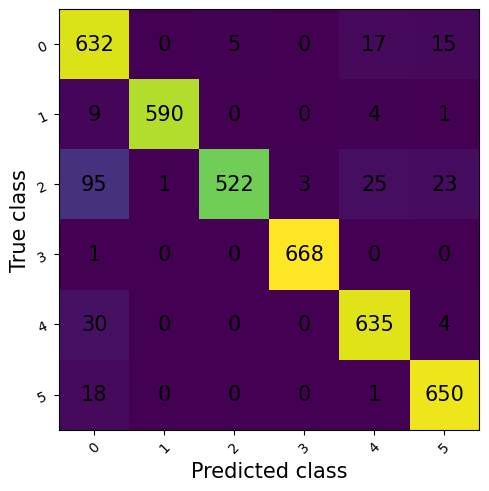

In [73]:
 plot_CM(test_loader, model)